# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_4D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [ ]:
# Parameters

dim_exp = 4  
data_points_exp = 20000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([20000, 2]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 138.05557250976562
iteration 0 loss 816.9677124023438


iteration 500 loss 12.3679838180542


iteration 1000 loss 11.12000560760498


iteration 1500 loss 9.905572891235352


iteration 2000 loss 8.110106468200684


iteration 2500 loss 5.881944179534912


iteration 3000 loss 3.488952159881592


iteration 3500 loss 1.576574444770813


iteration 4000 loss 0.5837982296943665


iteration 4500 loss 0.2367277294397354


iteration 5000 loss 0.11946146190166473


iteration 5500 loss 0.07846511900424957


iteration 6000 loss 0.0576256588101387


iteration 6500 loss 0.044274408370256424


iteration 7000 loss 0.03536202386021614


iteration 7500 loss 0.02872427925467491


iteration 8000 loss 0.023014653474092484


iteration 8500 loss 0.018722763285040855


iteration 9000 loss 0.015094506554305553


iteration 9500 loss 0.011930890381336212


iteration 10000 loss 0.014326928183436394


iteration 10500 loss 0.007851677015423775


iteration 11000 loss 0.00644277036190033


iteration 11500 loss 0.005280169192701578


iteration 12000 loss 0.0043134321458637714


iteration 12500 loss 0.0036574804689735174


iteration 13000 loss 0.0032078430522233248


iteration 13500 loss 0.002786788856610656


iteration 14000 loss 0.002392651978880167


iteration 14500 loss 0.0020306422375142574


iteration 15000 loss 0.0017060855170711875


iteration 15500 loss 0.04620377719402313


iteration 16000 loss 0.0013210450997576118


iteration 16500 loss 0.0012127910740673542


iteration 17000 loss 0.0010969581780955195


iteration 17500 loss 0.000976618961431086


iteration 18000 loss 0.0008559768320992589


iteration 18500 loss 0.0008202221943065524


iteration 19000 loss 0.0007249932968989015


iteration 19500 loss 0.0006875654798932374


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.0006458567222580314


iteration 20500 loss 0.0006408273475244641


iteration 21000 loss 0.0006344822468236089


iteration 21500 loss 0.0006265118718147278


iteration 22000 loss 0.0006165764643810689


iteration 22500 loss 0.0006043400499038398


iteration 23000 loss 0.000589475966989994


iteration 23500 loss 0.0005717550520785153


iteration 24000 loss 0.0005510090850293636


iteration 24500 loss 0.0005273082642816007


iteration 25000 loss 0.000500714872032404


iteration 25500 loss 0.00047120521776378155


iteration 26000 loss 0.0004390598041936755


iteration 26500 loss 0.00041102798422798514


iteration 27000 loss 0.00039750346331857145


iteration 27500 loss 0.0003818160912487656


iteration 28000 loss 0.0003638484631665051


iteration 28500 loss 0.000343692401656881


iteration 29000 loss 0.0003216074255760759


iteration 29500 loss 0.0003092171682510525


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=2) ---
loss 8.635772705078125


loss -34.645206451416016


loss -55.54075622558594


loss -63.315826416015625


loss -66.62940216064453


loss -67.95564270019531


loss -68.39032745361328


loss -68.49602508544922


loss -68.5130844116211


loss -68.51468658447266


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.5147705078125


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.5147705078125


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.5147705078125


loss -68.51476287841797


loss -68.5147705078125


loss -68.51476287841797


loss -68.5147705078125


loss -68.5147705078125


loss -68.51476287841797


loss -68.51476287841797


loss -68.5147705078125


loss -68.51476287841797


loss -68.51476287841797


loss -68.51476287841797


loss -68.5147705078125


loss -68.5147705078125


final mse:  2.8435043208929756e-09
max, min: 1.9919945 -2.0094671
loss 8.635772705078125


loss -34.38516616821289


loss -54.833045959472656


loss -62.75410461425781


loss -66.28229522705078


loss -67.68666076660156


loss -68.12761688232422


loss -68.22796630859375


loss -68.24292755126953


loss -68.24422454833984


loss -68.24427795410156


loss -68.24427795410156


loss -68.24427795410156


loss -68.24427795410156


loss -68.2442855834961


loss -68.24427795410156


loss -68.24427795410156


loss -68.2442855834961


loss -68.24427795410156


loss -68.2442855834961


loss -68.2442855834961


loss -68.24427795410156


loss -68.24427795410156


loss -68.24427795410156


loss -68.24427795410156


loss -68.2442855834961


loss -68.2442855834961


loss -68.2442855834961


loss -68.24427795410156


loss -68.24427795410156


loss -68.24427795410156


loss -68.2442855834961


loss -68.2442855834961


loss -68.2442855834961


loss -68.2442855834961


loss -68.24427795410156


loss -68.24427795410156


loss -68.2442855834961


loss -68.2442855834961


loss -68.2442855834961


final mse:  1.3332880355321208e-09
max, min: 1.9918947 -2.008147


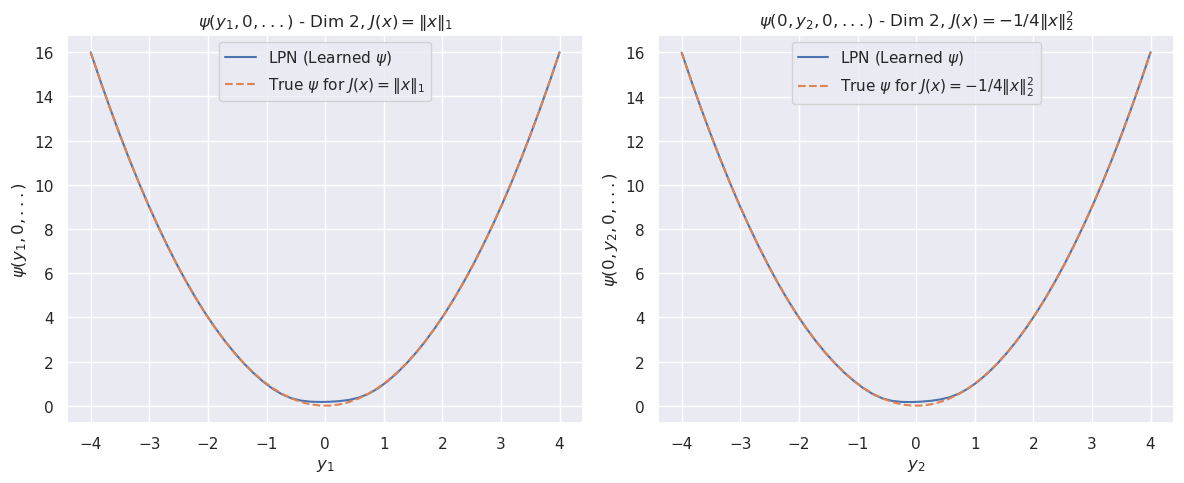

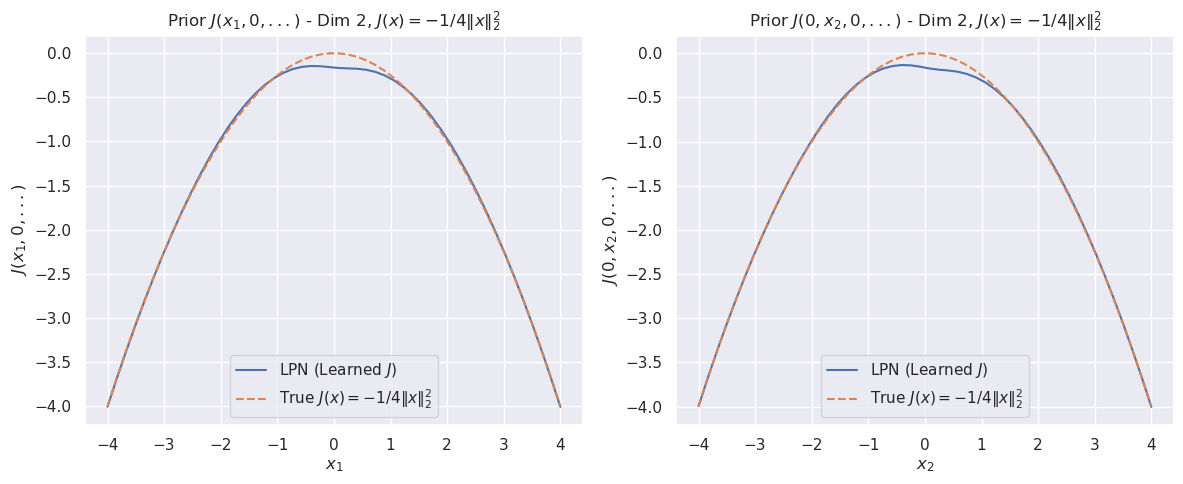

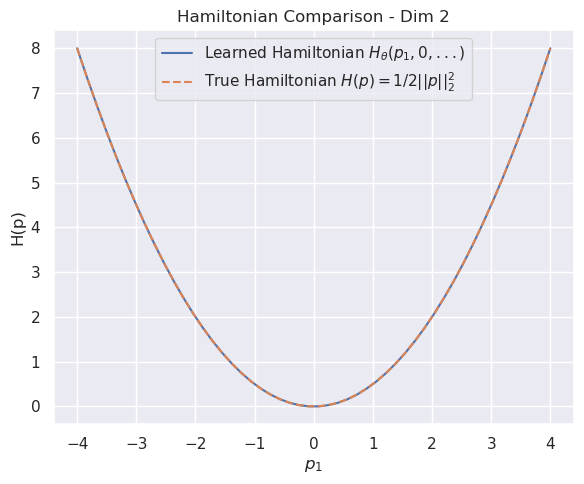

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


Generated G samples: G_samples_tensor shape torch.Size([20000, 1])


In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 158.38284301757812
iteration 0 loss 3394.31396484375


iteration 500 loss 14.692205429077148


iteration 1000 loss 8.478858947753906


iteration 1500 loss 8.141718864440918


iteration 2000 loss 7.841736316680908


iteration 2500 loss 7.450433254241943


iteration 3000 loss 6.952464580535889


iteration 3500 loss 6.334978103637695


iteration 4000 loss 5.586015701293945


iteration 4500 loss 4.643270969390869


iteration 5000 loss 3.4069273471832275


iteration 5500 loss 1.994170069694519


iteration 6000 loss 0.9572235941886902


iteration 6500 loss 0.4134964644908905


iteration 7000 loss 0.19755278527736664


iteration 7500 loss 0.11237117648124695


iteration 8000 loss 0.0712289810180664


iteration 8500 loss 0.04479551315307617


iteration 9000 loss 0.027626732364296913


iteration 9500 loss 0.01705649308860302


iteration 10000 loss 0.010843215510249138


iteration 10500 loss 0.007113578729331493


iteration 11000 loss 0.0055366153828799725


iteration 11500 loss 0.004366847220808268


iteration 12000 loss 0.003439804771915078


iteration 12500 loss 0.002713864902034402


iteration 13000 loss 0.002152141183614731


iteration 13500 loss 0.0019145971164107323


iteration 14000 loss 0.0017281027976423502


iteration 14500 loss 0.001560008036904037


iteration 15000 loss 0.00139886315446347


iteration 15500 loss 0.0012435571989044547


iteration 16000 loss 0.0010926297400146723


iteration 16500 loss 0.0010552431922405958


iteration 17000 loss 0.0009808458853513002


iteration 17500 loss 0.0009235477191396058


iteration 18000 loss 0.0008673410047776997


iteration 18500 loss 0.0008081401465460658


iteration 19000 loss 0.000745037104934454


iteration 19500 loss 0.0006789729231968522


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.0006754398928023875


iteration 20500 loss 0.0006699093501083553


iteration 21000 loss 0.000663547427393496


iteration 21500 loss 0.0006564260111190379


iteration 22000 loss 0.0006485572084784508


iteration 22500 loss 0.0006398077821359038


iteration 23000 loss 0.0006299220840446651


iteration 23500 loss 0.0006188138504512608


iteration 24000 loss 0.000606366025749594


iteration 24500 loss 0.0005923067219555378


iteration 25000 loss 0.0005763742374256253


iteration 25500 loss 0.0005580902216024697


iteration 26000 loss 0.000537084590177983


iteration 26500 loss 0.0005131473881192505


iteration 27000 loss 0.00048621356836520135


iteration 27500 loss 0.00046701496466994286


iteration 28000 loss 0.00045957244583405554


iteration 28500 loss 0.00045082499855197966


iteration 29000 loss 0.0004402165359351784


iteration 29500 loss 0.00042747132829390466


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


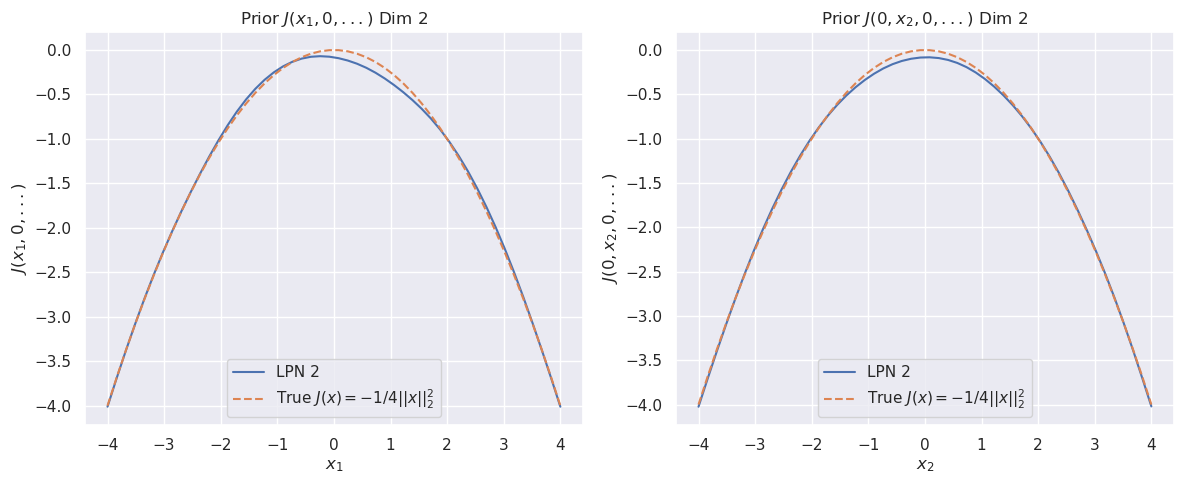

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)